Fundamentos de analítica 2 (clase 4) - Diego Fernando Agudelo - Universidad ICESI - diegoagudelo30@gmail.com

# Fundamentos-analitica-II
Repositorio de trabajos para la asignatura de la maestría en Ciencia de Datos

FACULTAD DE INGENIERÍA, DISEÑO Y CIENCIAS 
APLICADAS 
MAESTRÍA EN CIENCIA DE DATOS 
TIC 60153 – Fundamentos de analítica II 

Grupo: 

DANIEL DELGADO - FABIAN SALAZAR FIGUEROA

En días recientes trabajamos con una compañía de comestibles que estaba interesada en predecir el comportamiento de las ventas (en unidades) de sus dos productos estrella. Fuimos contratados para generar un modelo que permita pronosticar las ventas del siguiente mes de cada uno de esos dos productos. La base de datos disponible en el archivo Examen.csv tiene la información de cada uno de los productos desde enero de 2008.

Su misión es encontrar el mejor modelo para pronosticar cada una de las series. Usted debe entregar un informe escrito de no más de cuatro páginas que presente los resultados al cliente y cuente el proceso para llegar a los pronósticos. Vea las instrucciones para asegurar que entrega los archivos requeridos

### Instrucciones
El examen se compone de dos partes:
- La primera corresponde a una parte de selección múltiple con 19 preguntas que se responderán en el salón de clase en 45 minutos. Esa primera parte tiene una calificación de 1 a 5.
-La segunda parte corresponde a la parte práctica del examen y tiene también una calificación de 1 a 5.

- La nota de este examen parcial corresponderá al promedio ponderado de las dos notas, donde la parte práctica tiene un peso de 40 % y la parte de selección múltiple de 60 %.
- Usted tiene hasta el 30 de agosto a las 12:00 pm para enviar los archivos por correo, estos archivos deben tener su nombre.
- Sólo se calificaran exámenes en formato pdf. Cualquier otro formato no será tenido en cuenta.
- El examen debe estar acompañado de un notebook (ipynb)  que incluya todo los códigos de python que se emplean para obtener sus resultados.
- El nombre del archivo debe tener su nombre. No se recibirán archivos en otro formato.
- Esta parte del examen es para realizar en casa y debe reflejar el trabajo individual.

## **1. Carga de paquetes**

In [70]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
#!pip install fastai wwf bayesian-optimization -q --upgrade
from bayes_opt import BayesianOptimization
from datetime import datetime, timedelta

## **2. Carga de datos**

Nuestra primera tarea será leer el archivo csv. Para eso podemos emplear el paquete Pandas. Carguemos los datos en un objeto que denominaremos data.

In [71]:
# Usamos su columna de meses que no tiene nombre de índice
data = pd.read_csv(r"https://raw.githubusercontent.com/alfa7g7/Fundamentos-analitica-II/main/UNIDAD%20I/Clase%204/Examen.csv", sep=',')
data.head()

,Unnamed: 0,producto1,producto2
0,1,4000.000000,3000.000000
1,2,3997.400893,3010.686220
2,3,3978.605317,3022.018584
3,4,3986.454125,3033.920990
4,5,3979.695678,3038.402098


## **3. EDA**

Procedemos a hacer un análisis corto de EDA para verificar tamaño del conjunto de datos para cada serie de tiempo, nulos (si hay) y algunas cuantificaciones estadísticas

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  127 non-null    int64  
 1   producto1   127 non-null    float64
 2   producto2   127 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.1 KB


In [73]:
#Determinamos si existen nulos en las series de tiempo
data.isnull().sum()

Unnamed: 0    0
producto1     0
producto2     0
dtype: int64

In [74]:
# Estadsiticas del conjunto de datos de tendencia central
data.describe()

,Unnamed: 0,producto1,producto2
count,127.000000,127.000000,127.000000
mean,64.000000,3843.571660,3381.037664
std,36.805797,100.234821,167.504363
min,1.000000,3637.047639,3000.000000
25%,32.500000,3756.853812,3269.194001
50%,64.000000,3840.644019,3426.048401
75%,95.500000,3950.071775,3508.941718
max,127.000000,4000.000000,3606.440615


Ahora debemos convertir en índice la variable sin nombre que representa los meses desde enero del 2008 como lo indica el enunciado del problema y expresarla en forma de fecha para mejorar el entendimiento y procesamiento

In [75]:
# Renombrar la columna 'Unnamed: 0' a 'Mes'
data.rename(columns={'Unnamed: 0': 'Mes'}, inplace=True)

# Función para convertir un número de mes a una fecha
def convertir_mes_a_fecha(mes, start_date):
    # Calcular el año y el mes correspondientes
    year = start_date.year + (mes - 1) // 12
    month = (start_date.month + (mes - 1) % 12 - 1) % 12 + 1
    return datetime(year, month, 1)

# Fecha de inicio (enero de 2008)
start_date = datetime(2008, 1, 1)

# Aplicar la función a la columna 'Mes'
data['Mes'] = data['Mes'].apply(lambda x: convertir_mes_a_fecha(x, start_date))

print(data)


           Mes    producto1    producto2
0   2008-01-01  4000.000000  3000.000000
1   2008-02-01  3997.400893  3010.686220
2   2008-03-01  3978.605317  3022.018584
3   2008-04-01  3986.454125  3033.920990
4   2008-05-01  3979.695678  3038.402098
..         ...          ...          ...
122 2018-03-01  3664.610771  3429.293034
123 2018-04-01  3650.881839  3437.099467
124 2018-05-01  3651.788470  3453.155282
125 2018-06-01  3637.047639  3472.528345
126 2018-07-01  3641.990873  3476.058092

[127 rows x 3 columns]


In [76]:
# Establecer la columna 'Mes' como índice
data.set_index('Mes', inplace=True)

print(data)

              producto1    producto2
Mes                                 
2008-01-01  4000.000000  3000.000000
2008-02-01  3997.400893  3010.686220
2008-03-01  3978.605317  3022.018584
2008-04-01  3986.454125  3033.920990
2008-05-01  3979.695678  3038.402098
...                 ...          ...
2018-03-01  3664.610771  3429.293034
2018-04-01  3650.881839  3437.099467
2018-05-01  3651.788470  3453.155282
2018-06-01  3637.047639  3472.528345
2018-07-01  3641.990873  3476.058092

[127 rows x 2 columns]


(127, 3)


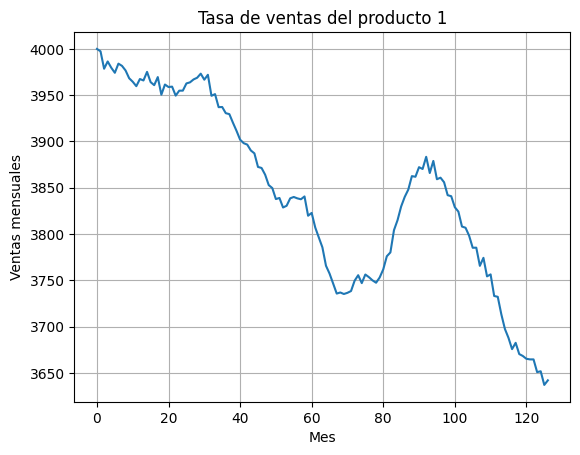

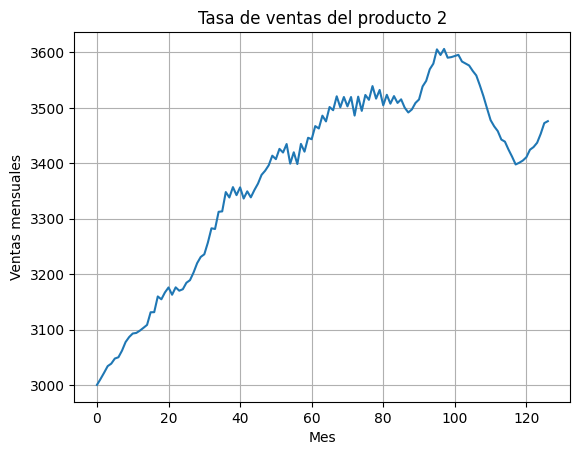

In [61]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos de producto1 y produto2
plt.title("Tasa de ventas del producto 1")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.plot(data[["producto1"]])
plt.grid()
plt.show()

plt.title("Tasa de ventas del producto 2")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.plot(data[["producto2"]])
plt.grid()
plt.show()

Encontrando los componentes de las series de tiempo para los productos 1 y 2

En algunas ocasiones puede ser útil empezar nuestro análisis descomponiendo la serie de tiempo en sus componentes: **tendencia**, **estacionalidad** y **componente puramente aleatorio**. Una forma de hacer esto es empleando la función seasonal_decompose.

In [55]:
td_componentes_producto1 = seasonal_decompose(data[["producto1"]],model="additive")
fig = td_componentes_producto1.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

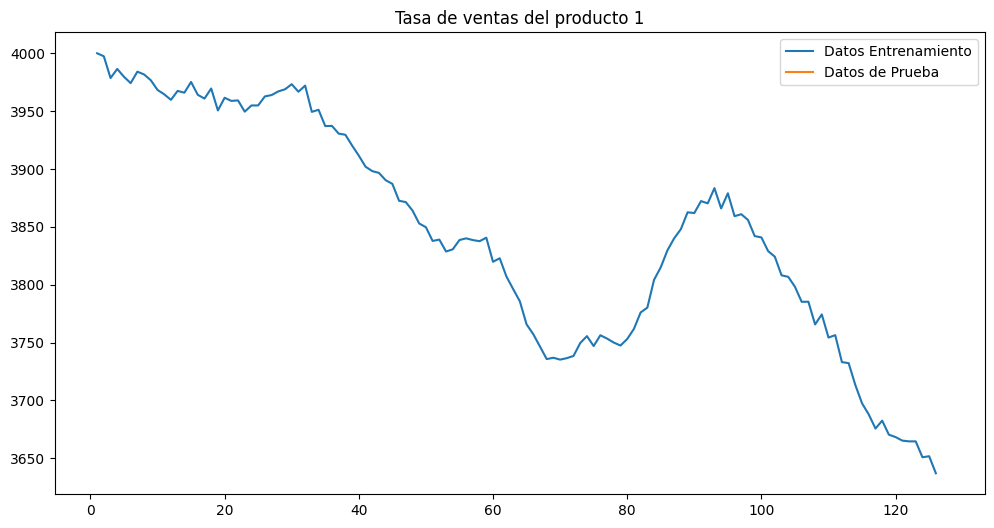

In [46]:
train_len = len(data) - 1 
train_producto1 = data[["producto1"]][:train_len]
test_producto1 = data[["producto1"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.title("Tasa de ventas del producto 1")
plt.plot(train_producto1,label="Datos Entrenamiento")
plt.plot(test_producto1,label="Datos de Prueba")
plt.legend()
plt.show()

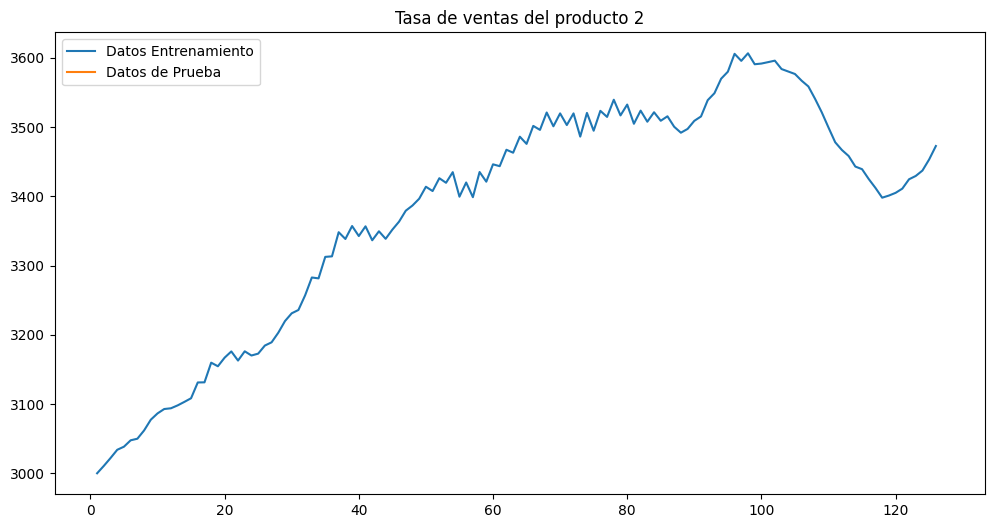

In [47]:
train_len = len(data) - 1 
train_producto1 = data[["producto2"]][:train_len]
test_producto1 = data[["producto2"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.title("Tasa de ventas del producto 2")
plt.plot(train_producto1,label="Datos Entrenamiento")
plt.plot(test_producto1,label="Datos de Prueba")
plt.legend()
plt.show()

## **Por definir**

## **3. Optimización Bayesiana**

In [45]:
def train_and_evaluate_RMSE(error,trend,seasonal,alpha,beta,gamma):
    """Function we want to maximize (Black box)

    It first trains a model with the training set using the received hyper
    parameterts, and then evaluatesand returns the Min RMSE over the test set.
    """

    alpha = round(alpha,2)
    beta  = round(beta,2)
    gamma = round(gamma,2)

    print(error,trend,seasonal)
    print(alpha,beta,gamma)
    error1 = ["add","mul"]
    trend1 = ["add","mul",None]
    seasonal1 = ["add","mul",None]

    model = ETSModel(endog=train_producto1["producto1"],error=error1[round(error)],trend=trend1[round(trend)],seasonal=seasonal1[round(seasonal)])

    params = {'smoothing_level': alpha,'smoothing_trend': beta,'smoothing_seasonal':gamma}

    if trend1[round(trend)] == None:
      params.pop('smoothing_trend')
    if seasonal1[round(seasonal)] == None:
      params.pop('smoothing_seasonal')

    model_result = model.fit_constrained(params)

    point_forecast=model_result.forecast(1)
    rmse = np.sqrt(mean_squared_error(test_producto1["producto1"],point_forecast ))

    print(" target es: {},Eror test: {},Trend test: {},Seasonal test: {},Alpha model: {},Beta model: {}, Gamma model: {}".
          format(rmse,error1[round(error)],trend1[round(trend)],seasonal1[round(seasonal)],alpha,beta,gamma))

    return -rmse

In [42]:
pbounds = {'error':  (0,1),'trend':(0,2) , 'seasonal': (0,2), 'alpha':(0.01,0.99) , "beta" :(0.01,0.99),"gamma" :(0.01,0.99) }

In [43]:
optimizer = BayesianOptimization(
    f=train_and_evaluate_RMSE,
    pbounds=pbounds,
    random_state=1,
    verbose=2
)

In [44]:
import warnings
warnings.filterwarnings("ignore")
optimizer.maximize(init_points=3, n_iter=100)

|   iter    |  target   |   alpha   |   beta    |   error   |   gamma   | seasonal  |   trend   |
-------------------------------------------------------------------------------------------------
0.00011437481734488664 0.1846771895375956 0.2935117816342261
0.42 0.72 0.31


AssertionError: 

In [40]:
optimizer.max